In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install pandas_datareader

You should consider upgrading via the 'C:\Users\dorot\PycharmProjects\KaggleStudy\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install keras

You should consider upgrading via the 'C:\Users\dorot\PycharmProjects\KaggleStudy\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
!pip install tensorflow

You should consider upgrading via the 'C:\Users\dorot\PycharmProjects\KaggleStudy\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [5]:
# Import the python libraries
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

# matplotlib.pyplot 스타일시트 설정
plt.style.use('fivethirtyeight')

In [6]:
!pip install yfinance

You should consider upgrading via the 'C:\Users\dorot\PycharmProjects\KaggleStudy\venv\Scripts\python.exe -m pip install --upgrade pip' command.


# 삼성전자 주가 예측해보기📈

## 삼성전자 5년치 주가데이터 가져오기
**yfinance**는 Yahoo Finance에서 제공하는 데이터에 접근할 수 있는 API로, 이것을 활용해서 주가데이터를 수집했다.

In [7]:
import yfinance as yf
import pandas_datareader.data as pdr # 오픈 데이터를 쉽게 가져올 수 있음

yf.pdr_override()

#Get the stock starting date
start_date = '07-02-2017'

# Get the stock ending date
end_date = '07-02-2022'

# Get the stocks ending date aka todays date and format it in the form YYYY-MM-DD
# today = datetime.today().strftime('%d-%m-%Y')

In [8]:
start = datetime.strptime(start_date, '%d-%m-%Y')
end = datetime.strptime(end_date, '%d-%m-%Y')

# end = datetime.strptime(today, '%d-%m-%Y')

In [9]:
start

datetime.datetime(2017, 2, 7, 0, 0)

In [10]:
end

datetime.datetime(2022, 2, 7, 0, 0)

In [11]:
#각 주식의 일별 종가 데이터를 저장할 데이터 프레임을 생성
#Create a dataframe to store the adjusted close price of the stocks
data = pd.DataFrame()

In [12]:
#삼성 주가데이터 가져오기
data = pdr.get_data_yahoo('005930.KS', data_source='yahoo', 
                               start=start , end=end)

[*********************100%***********************]  1 of 1 completed


In [13]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-02-07,39560.0,39580.0,38760.0,38820.0,33687.878906,14041800
2017-02-08,38740.0,38780.0,38200.0,38400.0,33323.402344,17092950
2017-02-09,38780.0,38840.0,38220.0,38400.0,33323.402344,13694150
2017-02-10,38400.0,38760.0,38300.0,38360.0,33288.695312,11020750
2017-02-13,37740.0,38060.0,37720.0,37960.0,32941.574219,11102050
...,...,...,...,...,...,...
2022-01-26,74000.0,74000.0,74000.0,74000.0,74000.000000,0
2022-01-27,73800.0,74000.0,71300.0,71300.0,71300.000000,22274777
2022-01-28,71300.0,73700.0,71200.0,73300.0,73300.000000,21367447


## EDA

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1224 entries, 2017-02-07 to 2022-02-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1224 non-null   float64
 1   High       1224 non-null   float64
 2   Low        1224 non-null   float64
 3   Close      1224 non-null   float64
 4   Adj Close  1224 non-null   float64
 5   Volume     1224 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 66.9 KB


In [15]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1.224000e+03
mean,56041.192810,56576.348039,55488.635621,56016.446078,52466.538601,1.517149e+07
std,13770.557612,13866.502411,13663.177192,13736.602638,15168.141119,8.418661e+06
min,37080.000000,37600.000000,36850.000000,37450.000000,32611.820312,0.000000e+00
25%,46087.500000,46450.000000,45600.000000,46047.500000,41379.050781,9.773693e+06
50%,50660.000000,51200.000000,50060.000000,50610.000000,45802.542969,1.293674e+07
75%,61375.000000,62000.000000,60775.000000,61425.000000,58363.375000,1.812242e+07
max,90300.000000,96800.000000,89500.000000,91000.000000,89367.750000,9.030618e+07


In [16]:
data.shape

(1224, 6)

In [17]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## 중간가격 구하기

In [18]:
high_prices = data['High'].values  # 고가
low_prices = data['Low'].values    # 저가

mid_prices = (high_prices + low_prices) / 2
mid_prices

array([39170., 38490., 38530., ..., 72450., 74100., 74000.])

## Create Windows
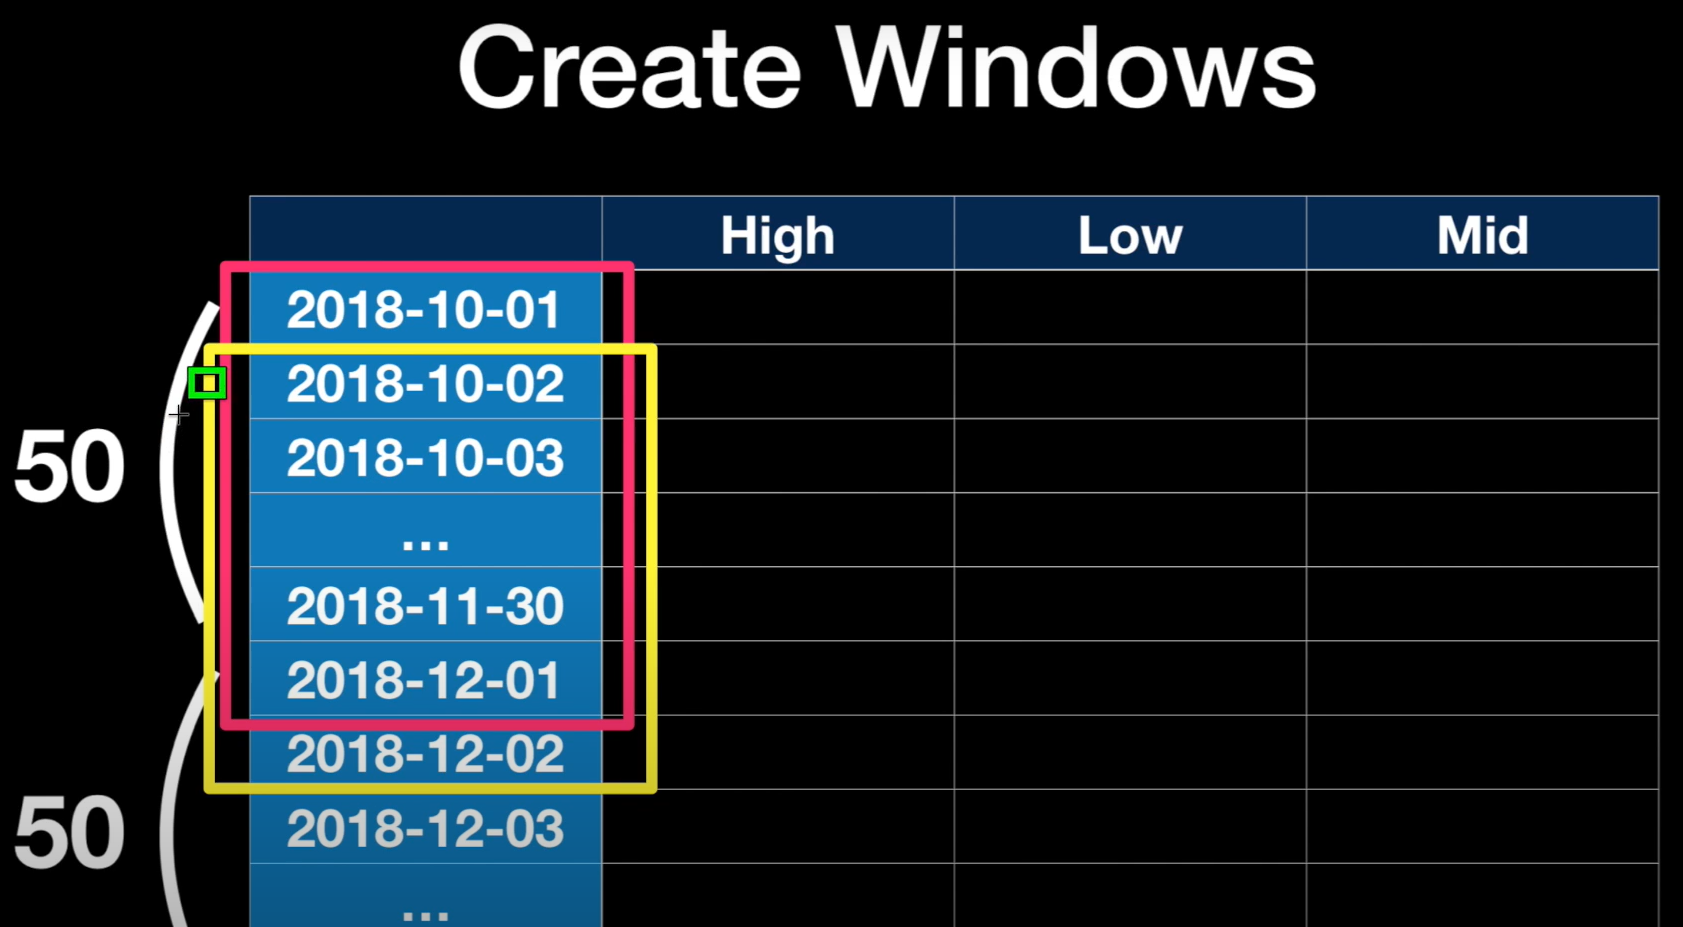  
window 하나에 총 51개 레코드의 데이터를 저장

In [19]:
seq_len = 50
sequence_length = seq_len + 1   #50개의 데이터 + 50개 데이터를 바탕으로 계산된 예측값 1개

result = []

for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])  #중간값으로 윈도우를 채움

In [20]:
result

[array([39170., 38490., 38530., 38530., 37890., 37790., 37520., 38070.,
        37660., 38470., 38990., 39160., 39230., 38580., 37920., 38360.,
        39140., 39440., 39720., 40060., 40380., 40160., 40140., 40510.,
        41020., 41120., 41860., 42110., 41930., 42220., 42020., 42030.,
        41530., 41530., 41610., 41770., 42160., 41610., 41510., 41850.,
        41970., 41840., 41490., 41720., 41760., 41820., 42060., 42010.,
        41800., 41550., 41160.]),
 array([38490., 38530., 38530., 37890., 37790., 37520., 38070., 37660.,
        38470., 38990., 39160., 39230., 38580., 37920., 38360., 39140.,
        39440., 39720., 40060., 40380., 40160., 40140., 40510., 41020.,
        41120., 41860., 42110., 41930., 42220., 42020., 42030., 41530.,
        41530., 41610., 41770., 42160., 41610., 41510., 41850., 41970.,
        41840., 41490., 41720., 41760., 41820., 42060., 42010., 41800.,
        41550., 41160., 40440.]),
 array([38530., 38530., 37890., 37790., 37520., 38070., 37660., 3847

In [21]:
len(result)

1173

## Normalize Data
모델의 예측 정확도를 높여주기 위함  

In [22]:
normalized_data = []

for window in result:
    normalized_window = [((float(p)/float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)
result

array([[ 0.        , -0.01736022, -0.01633903, ...,  0.06714322,
         0.06076079,  0.05080419],
       [ 0.        ,  0.00103923,  0.00103923, ...,  0.07950117,
         0.06936867,  0.05066251],
       [ 0.        ,  0.        , -0.01661043, ...,  0.0682585 ,
         0.04957176,  0.06254866],
       ...,
       [ 0.        , -0.0076762 , -0.01465457, ...,  0.034194  ,
         0.03279833,  0.01395673],
       [ 0.        , -0.00703235, -0.00492264, ...,  0.04078762,
         0.02180028,  0.01898734],
       [ 0.        ,  0.00212465,  0.04957507, ...,  0.02903683,
         0.02620397,  0.04957507]])

In [23]:
result.shape

(1173, 51)

## Split dataset ( train : test  = 90 : 10 )

In [24]:
# split train and test data  (90 : 10)
row = int(round(result.shape[0] * 0.9))  # result 레코드의 90%
row

1056

In [25]:
train = result[:row, :]  # 전체의 90%
train

array([[ 0.        , -0.01736022, -0.01633903, ...,  0.06714322,
         0.06076079,  0.05080419],
       [ 0.        ,  0.00103923,  0.00103923, ...,  0.07950117,
         0.06936867,  0.05066251],
       [ 0.        ,  0.        , -0.01661043, ...,  0.0682585 ,
         0.04957176,  0.06254866],
       ...,
       [ 0.        ,  0.00439975,  0.00691389, ...,  0.01005657,
         0.03645506,  0.0389692 ],
       [ 0.        ,  0.00250313,  0.01001252, ...,  0.03191489,
         0.03441802,  0.02503129],
       [ 0.        ,  0.00749064,  0.0093633 , ...,  0.03183521,
         0.02247191,  0.01872659]])

In [26]:
train.shape

(1056, 51)

### train dataset

#### 독립변수 (x)

In [27]:
x_train = train[:, :-1]         # target 제외한 50개 값만(예측을 위한 데이터)
x_train

array([[ 0.        , -0.01736022, -0.01633903, ...,  0.07250447,
         0.06714322,  0.06076079],
       [ 0.        ,  0.00103923,  0.00103923, ...,  0.08599636,
         0.07950117,  0.06936867],
       [ 0.        ,  0.        , -0.01661043, ...,  0.07838048,
         0.0682585 ,  0.04957176],
       ...,
       [ 0.        ,  0.00439975,  0.00691389, ..., -0.00565682,
         0.01005657,  0.03645506],
       [ 0.        ,  0.00250313,  0.01001252, ...,  0.00563204,
         0.03191489,  0.03441802],
       [ 0.        ,  0.00749064,  0.0093633 , ...,  0.02933833,
         0.03183521,  0.02247191]])

In [28]:
x_train.shape

(1056, 50)

In [29]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train

array([[[ 0.        ],
        [-0.01736022],
        [-0.01633903],
        ...,
        [ 0.07250447],
        [ 0.06714322],
        [ 0.06076079]],

       [[ 0.        ],
        [ 0.00103923],
        [ 0.00103923],
        ...,
        [ 0.08599636],
        [ 0.07950117],
        [ 0.06936867]],

       [[ 0.        ],
        [ 0.        ],
        [-0.01661043],
        ...,
        [ 0.07838048],
        [ 0.0682585 ],
        [ 0.04957176]],

       ...,

       [[ 0.        ],
        [ 0.00439975],
        [ 0.00691389],
        ...,
        [-0.00565682],
        [ 0.01005657],
        [ 0.03645506]],

       [[ 0.        ],
        [ 0.00250313],
        [ 0.01001252],
        ...,
        [ 0.00563204],
        [ 0.03191489],
        [ 0.03441802]],

       [[ 0.        ],
        [ 0.00749064],
        [ 0.0093633 ],
        ...,
        [ 0.02933833],
        [ 0.03183521],
        [ 0.02247191]]])

In [30]:
x_train.shape

(1056, 50, 1)

#### 종속변수 (y)

In [31]:
y_train = train[:, -1]  # 마지막 1개 (target. 앞의 50개 데이터를 바탕으로 예측하는 값)
y_train

array([0.05080419, 0.05066251, 0.06254866, ..., 0.0389692 , 0.02503129,
       0.01872659])

In [32]:
y_train.shape

(1056,)

### test dataset

#### 독립변수 (x)

In [33]:
x_test = result[row:, :-1]  # 전체의 10% , target 제외한 50개 값만
x_test

array([[ 0.        ,  0.00185874,  0.01672862, ...,  0.02416357,
         0.01486989,  0.01115242],
       [ 0.        ,  0.0148423 ,  0.01546073, ...,  0.01298701,
         0.00927644,  0.00494743],
       [ 0.        ,  0.00060938,  0.00182815, ..., -0.00548446,
        -0.00975015, -0.0353443 ],
       ...,
       [ 0.        , -0.0076762 , -0.01465457, ...,  0.05024424,
         0.034194  ,  0.03279833],
       [ 0.        , -0.00703235, -0.00492264, ...,  0.04219409,
         0.04078762,  0.02180028],
       [ 0.        ,  0.00212465,  0.04957507, ...,  0.04815864,
         0.02903683,  0.02620397]])

In [34]:
x_test.shape

(117, 50)

In [35]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test

array([[[ 0.        ],
        [ 0.00185874],
        [ 0.01672862],
        ...,
        [ 0.02416357],
        [ 0.01486989],
        [ 0.01115242]],

       [[ 0.        ],
        [ 0.0148423 ],
        [ 0.01546073],
        ...,
        [ 0.01298701],
        [ 0.00927644],
        [ 0.00494743]],

       [[ 0.        ],
        [ 0.00060938],
        [ 0.00182815],
        ...,
        [-0.00548446],
        [-0.00975015],
        [-0.0353443 ]],

       ...,

       [[ 0.        ],
        [-0.0076762 ],
        [-0.01465457],
        ...,
        [ 0.05024424],
        [ 0.034194  ],
        [ 0.03279833]],

       [[ 0.        ],
        [-0.00703235],
        [-0.00492264],
        ...,
        [ 0.04219409],
        [ 0.04078762],
        [ 0.02180028]],

       [[ 0.        ],
        [ 0.00212465],
        [ 0.04957507],
        ...,
        [ 0.04815864],
        [ 0.02903683],
        [ 0.02620397]]])

In [36]:
x_test.shape

(117, 50, 1)

In [37]:
y_test = result[row:, -1]   # 전체의 10%, target 값만
y_test

array([ 0.00681537, -0.02102659, -0.05484461, -0.08587089, -0.09306569,
       -0.10158151, -0.09564684, -0.09796673, -0.09482759, -0.07311029,
       -0.06365884, -0.07484663, -0.08148148, -0.07363861, -0.05388471,
       -0.04494382, -0.04984424, -0.05448916, -0.05456775, -0.06479218,
       -0.06691222, -0.06477483, -0.06351183, -0.0555209 , -0.04042289,
       -0.04885591, -0.05012376, -0.0496586 , -0.02770781, -0.02946708,
       -0.033125  , -0.02961563, -0.06870706, -0.06954887, -0.07025316,
       -0.08259212, -0.08629442, -0.09640832, -0.0955374 , -0.11813013,
       -0.12666244, -0.11888112, -0.10872314, -0.113723  , -0.10619469,
       -0.12134412, -0.14736204, -0.14882033, -0.14468864, -0.13051471,
       -0.13230769, -0.10486418, -0.08897485, -0.06395736, -0.04158283,
       -0.03994584, -0.03661017, -0.03142077, -0.04489796, -0.05681818,
       -0.06864686, -0.07427056, -0.05376344, -0.04609218, -0.05099338,
       -0.07058824, -0.07409836, -0.07334643, -0.03891051, -0.01

In [38]:
y_test.shape

(117,)

In [39]:
x_train.shape, x_test.shape

((1056, 50, 1), (117, 50, 1))

1056일의 주가 데이터를 가지고 117일의 주가를 예측

## Build a Model

In [40]:
#1. 모델정의
model = Sequential()  #keras.models.Sequential()  : 모델을 순차적으로 정의하는 클래스

#2. 모델에 LSTM 레이어 추가
model.add(LSTM(50, return_sequences = True, input_shape=(50, 1)))  # input 사이즈 : (50, 1) 
model.add(LSTM(64, return_sequences = False))                      # 유닛 수 : 64개 (조정하면서 성능 테스트할 수 있음)

#3. FCL (Fully Connected Layer)
model.add(Dense(1, activation='linear'))  # 유닛 수: 1개 (다음날 하루의 데이터를 예측)

#4. 손실함수(loss function)로 MSE (Mean Squared Error)사용, optimizer로는 rmsprop 사용
model.compile(loss='mse', optimizer='rmsprop')

#5. 모델의 개요 출력
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


## Training & Prediction

In [41]:
!pip install sklearn

You should consider upgrading via the 'C:\Users\dorot\PycharmProjects\KaggleStudy\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [42]:
from sklearn.metrics import mean_squared_error, r2_score

# 학습 시작시간 체크
start = datetime.now()

#모델학습
model.fit(x_train, y_train, 
          validation_data = (x_test, y_test),
          batch_size = 10,  # 10개씩 묶어서 학습시킴
          epochs = 20)      # 20번 반복학습

# 예측
pred = model.predict(x_test)

# 학습 종료시간 체크
stop = datetime.now()

# 소요시간 계산
delta = stop - start

Epoch 1/20
106/106 [==============================] - 5s 26ms/step - loss: 0.0023 - val_loss: 6.5297e-04
Epoch 2/20
106/106 [==============================] - 2s 20ms/step - loss: 0.0011 - val_loss: 4.3912e-04
Epoch 3/20
106/106 [==============================] - 2s 20ms/step - loss: 7.6765e-04 - val_loss: 4.5654e-04
Epoch 4/20
106/106 [==============================] - 2s 20ms/step - loss: 6.2244e-04 - val_loss: 4.8521e-04
Epoch 5/20
106/106 [==============================] - 2s 20ms/step - loss: 4.7342e-04 - val_loss: 2.2126e-04
Epoch 6/20
106/106 [==============================] - 2s 20ms/step - loss: 4.1842e-04 - val_loss: 5.8411e-04
Epoch 7/20
106/106 [==============================] - 2s 20ms/step - loss: 3.6562e-04 - val_loss: 2.1098e-04
Epoch 8/20
106/106 [==============================] - 2s 20ms/step - loss: 3.3141e-04 - val_loss: 1.4068e-04
Epoch 9/20
106/106 [==============================] - 2s 20ms/step - loss: 3.1697e-04 - val_loss: 1.6487e-04
Epoch 10/20
106/106 [======

###  예측값을 시각화

In [43]:
!pip install seaborn

You should consider upgrading via the 'C:\Users\dorot\PycharmProjects\KaggleStudy\venv\Scripts\python.exe -m pip install --upgrade pip' command.


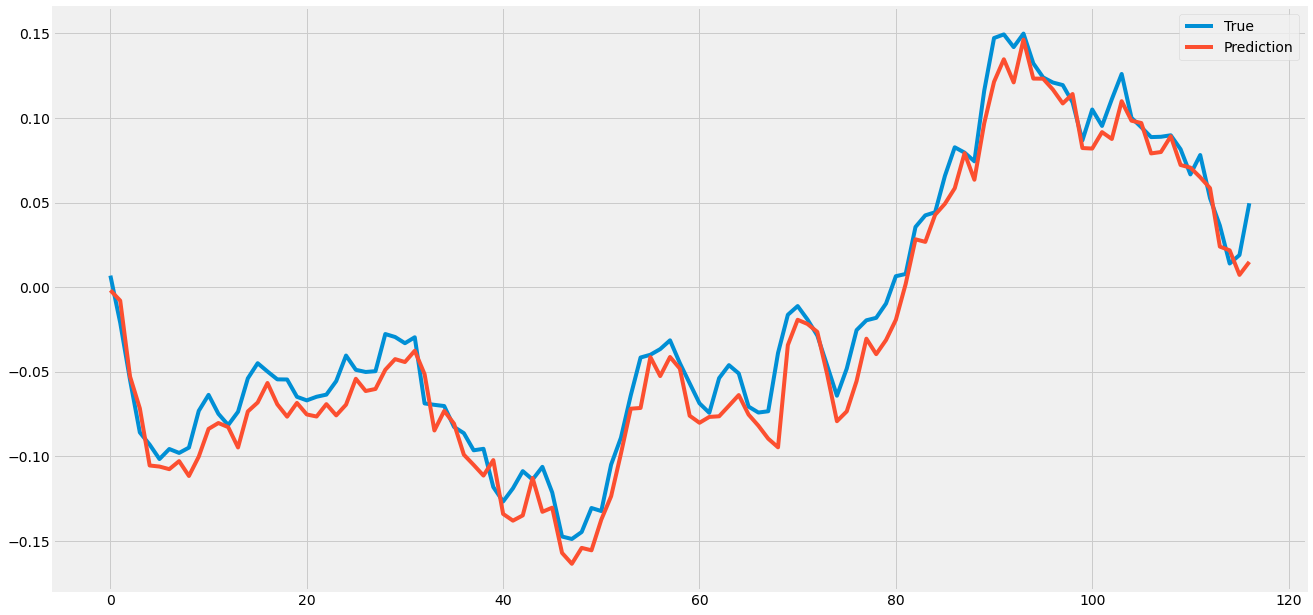

In [46]:
fig = plt.figure(facecolor = 'white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred,label='Prediction')
ax.legend()
# plt.figure(figsize=(20, 10))
plt.show()

## 모델평가

**1. MSE (Mean Squared Error)**  
    예측값과 실제값의 차이인 오차들의 제곱 평균
    
**2. R2 score**  
    분산기반 예측 성능 평가.  
    MAE, MSE와 같은 지표들은 데이터의 scale에 따라 값이 다르지만, R2은 상대적인 성능이 어느정도인지 직관적으로 판단할 수 있음.

**3. RMSE (Root Mean Squared Error)**  
    모델의 예측값과 실제 환경에서 관찰되는 값의 차이를 다룰 때 흔히 사용하는 평가방법  
    
**4. 소요시간**  
    학습부터 예측까지 소요되는 시간

In [45]:
# 평가결과 출력
print('LSTM\n')

# MSE
loss = mean_squared_error(y_test, pred)
print('MSE: ', loss)

# R2
r2 = r2_score(y_test, pred)
print('R2: ', r2)

# RMSE
err = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE: ', err)

# 소요시간
seconds = delta.seconds + delta.microseconds/1E6
print('Time to compute: ', seconds, 'seconds')

lstm = ('LSTM', loss, r2, err, seconds)

LSTM

MSE:  0.0002451774445967821
R2:  0.9610092610918014
RMSE:  0.01565814307626489
Time to compute:  47.095723 seconds
